In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import scipy.optimize as optimize
import tqdm

import sys
sys.path.append('../core')
sys.path.append('..')

from core import erm, gamp
from overlaps import Overlaps, average_overlaps
import core.calibration
import utility
import joint_density
import display as display_

import gcmpyo3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
alpha = 0.1
tau = 2.0

In [36]:
# theoretical prediction 

m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(alpha, tau**2, 1.0, "probit", 1e-4, True, False)

100%|██████████| 10000/10000 [00:00<00:00, 17706.35it/s]


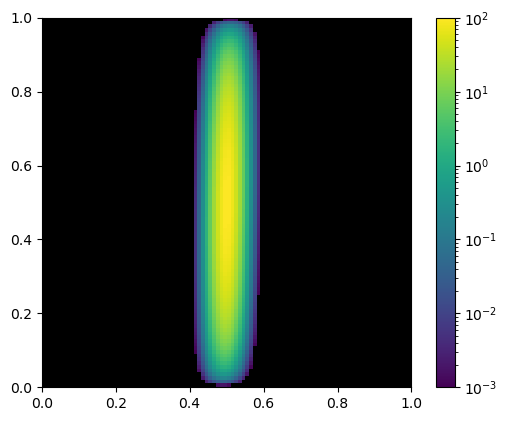

In [37]:
density = joint_density.get_p_one_bo_teacher_density(tau, np.array([[1.0, q], [q, q]]), 100, vmin=0., vmax=1., bo_on_rows = True)
display_.plot_from_density(density, mask_vmin=1e-3, mask_vmax=1e2)

In [42]:
# get empirical denstiy

def experimental_density(alpha, sigma, ntest):
    d = 300
    n = int(alpha * d)
    wstar = np.random.normal(0.0, 1.0, d)
    wstar = np.sqrt(d) * wstar / np.linalg.norm(wstar)
    X = np.random.normal(0.0, 1.0, (n, d)) / np.sqrt(d)
    Y = np.sign(X @ wstar + sigma * np.random.normal(0.0, 1.0, n))

    # get estimator from AMP
    res_gamp = gamp.iterate_gamp(X, Y, wstar, sig = sigma, verbose=False)
    what, vhat = res_gamp['estimator'], res_gamp['variances']

    # SAMPLE TEST SET
    bo_probas, teacher_probas = [], []
    batchsize = 1000
    nbatch = ntest // batchsize
    for i in range(nbatch):
        Xtest = np.random.normal(0.0, 1.0, (batchsize, d)) / np.sqrt(d)
        bo_probas += [utility.y_bo_proba(what, vhat, x, 1, sigma) for x in Xtest] 
        teacher_probas += [utility.y_teacher_proba(wstar, x, 1.0, sigma) for x in Xtest]

    # PLOT THE CALIBRATION
    n_ps         = 40
    dp           = 1. / n_ps
    bins         = [i*dp for i in range(n_ps)] + [1.]
    teacher_mean = [0]*n_ps
    for k in range(n_ps):
        print(k, len(bo_probas), len(bins))
        indexes = [l for l in range(ntest) if bins[k] < bo_probas[l] <= bins[k+1]]
        teacher_mean[k] = np.mean([teacher_probas[l] for l in indexes])

    # histogram
    ax = plt.gca()
    ax.set_facecolor((0., 0., 0.))

    hist = plt.hist2d(bo_probas, teacher_probas, bins=n_ps, density=True, norm=mpl.colors.LogNorm())
    plt.plot(np.linspace(0., 1., n_ps), teacher_mean)
    ax.set_aspect('equal', adjustable='box')
    plt.clim(1e-3, 1e2)
    plt.xlabel('$\hat{f}_{BO}$', fontsize=16)
    plt.ylabel('$f_{\star}$', fontsize=16)
    plt.xlim((0.0, 1.0))
    plt.ylim((0.0, 1.0))

    cbar = plt.colorbar()
    cbar.ax.minorticks_off()
    plt.show()


0 100000 41
1 100000 41
2 100000 41
3 100000 41
4 100000 41
5 100000 41
6 100000 41
7 100000 41
8 100000 41
9 100000 41
10 100000 41
11 100000 41
12 100000 41
13 100000 41
14 100000 41
15 100000 41
16 100000 41
17 100000 41


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


18 100000 41
19 100000 41
20 100000 41
21 100000 41
22 100000 41
23 100000 41
24 100000 41
25 100000 41
26 100000 41
27 100000 41
28 100000 41
29 100000 41
30 100000 41
31 100000 41
32 100000 41
33 100000 41
34 100000 41
35 100000 41
36 100000 41
37 100000 41
38 100000 41
39 100000 41


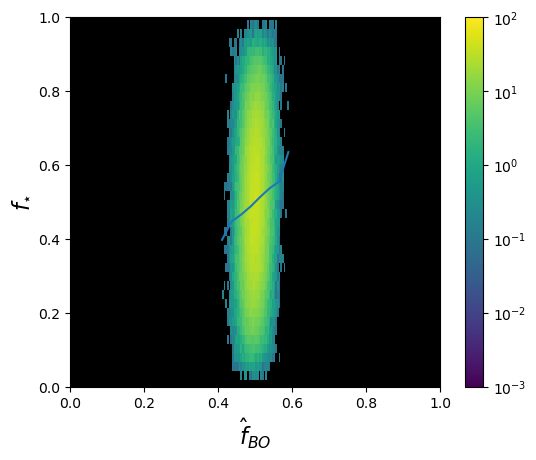

In [43]:
experimental_density(alpha, tau, 100000)